# LightHash simulator

In this notebook, we simulate the `LightHash` algorithm to determine the scalability of the technique in the presence of error.

We use the `simphox` package to implement the `LightHash` simulator.

In [13]:
from simphox.circuit import psvd
import pickle
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
matplotlib.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

from tqdm.notebook import tqdm as pbar
from scipy.special import erfc
from phox.apps.opow import random_lh_input, random_lh_matrix
from matplotlib.gridspec import GridSpec

## MZI network models

Generally, we consider the MZI operator $T$. We can model the beamsplitter error using $C_j = \cos\left(\frac{\pi}{4} + \delta_j\right), S_j = \sin\left(\frac{\pi}{4} + \delta_j\right)$, where $j = \ell, r$ stands for the left and right beamsplitters of the MZI.

$$
\begin{aligned}
        T(\theta, \phi) &= \begin{bmatrix}
      C_r(\lambda) & iS_r(\lambda) \\
      iS_r(\lambda) & C_r(\lambda)
\end{bmatrix} \begin{bmatrix}
       e^{i (\theta + \delta\theta(\lambda))} & 0 \\
      0 & 1
\end{bmatrix} \begin{bmatrix}
      C_\ell(\lambda) & iS_\ell(\lambda) \\
      iS_\ell(\lambda) & C_\ell(\lambda)
\end{bmatrix} \begin{bmatrix}
      e^{i (\phi + \delta\phi(\lambda))} & 0 \\
      0 & 1
\end{bmatrix}
    \end{aligned}
$$

The coupling errors are unitary random error variables that vary as $\delta_\ell, \delta_r = \delta(\lambda)$ and the phase / loss errors are grouped under a single complex random error term for $\delta \theta = \delta\eta(\lambda) + i\delta\xi(\lambda)$, where $\delta\eta(\lambda)$ is the phase error contribution and $\delta\xi(\lambda)$ is the loss error contribution.

The coupling errors $\delta(\lambda) \sim \mathcal{N}(\mu_{\mathrm{bs}} (\lambda - \lambda_c)^2, \sigma)$, where $\mu_{\mathrm{bs}} (\lambda - \lambda_c)^2$ is a dispersion contribution with scaling $\mu_{\mathrm{bs}}$ and $\sigma$ is fabrication or drift error which is present in an MZI.

The phase errors $\delta\eta(\lambda) \sim \mathcal{N}(\mu_{\eta} (\lambda - \lambda_c), \sigma_{\mathrm{ps}})$, where $\mu_\eta (\lambda - \lambda_c)$ is a dispersion contribution with scaling $\mu_{\eta}$ and $\sigma$ is crosstalk or drift error which is present in an MZI.

When incorporating loss imbalance error, we have $\delta\xi(\lambda) \sim \mathcal{N}(\mu_{\mathrm{loss}}\eta_j, \sigma_{\mathrm{loss}})$.

Loss imbalance errors $\delta\xi$ only in the positions of the phase shifters because they result from applying the common mode flow algorithm to localize loss errors to the phase shifts in any mesh network; all remaining losses are "pushed" to the branches. At the branches of the mesh, there should also be a bunch of loss elements in the model. Grating coupler efficiency variations and the algorithm to move all losses to the branches will combine to give an array of $N$ independent loss elements, but this can be effectively calibrated out by the network to achieve very low extinction ratios.

In [12]:
n = 64
k = 8
q = random_lh_matrix(n, n, num_vals=k)
l, d, r = psvd(q)
loss = []
errors = np.logspace(-3, -2, 10)
for err in pbar(errors):
    loss.append(np.array([l.add_error_variance(0, err).matrix() * d @ r.add_error_variance(0, err).matrix()
                          for i in range(10 * 128 // n)]))

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
GENERATE_DATA = False

# number of possible values (1-, 2-, and 3-bit)
ks = [2, 4, 8]

# number of inputs and outputs in the device
ns = [8, 16, 24, 32, 40, 48, 56, 64]
ns = ns[::-1]

# the possible errors
# errors = np.linspace(0.001, 0.01, 10)
errors = np.logspace(-3, -2, 10)

# complex standard deviation works as follows:
def complex_std(x):
    return np.sqrt(np.std(np.real(x)) ** 2 + np.std(np.imag(x)) ** 2)


if GENERATE_DATA:
    # the trials for phase, loss and coupling errors
    mats = {}
    phase_trials, loss_trials, coupling_trials = {}, {}, {}

    for n in ns:
        for k in ks:
            phase_trials[(n, k)] = []
            loss_trials[(n, k)] = []
            coupling_trials[(n, k)] = []
            mats[(n, k)] = []
            print(f'n = {n}, k = {k}')
            for _ in pbar(range(10)):
                loss = []
                coupling = []
                phases = []
                q = random_lh_matrix(n, n, num_vals=k)
                l, d, r = psvd(q)
                mats[(n, k)].append(q)
                for err in errors:
                    loss.append(np.array([l.add_error_variance(0, err).matrix() * d @ r.add_error_variance(0, err).matrix()
                                          for i in range(10 * 128 // n)]))
                for err in errors:
                    coupling.append(np.array([l.add_error_variance(err).matrix() * d @ r.add_error_variance(err).matrix()
                                              for i in range(10 * 128 // n)]))
                for err in errors:
                    phases.append(np.array([l.matrix(l.phases(err)) * d @ r.matrix(r.phases(err))
                                            for i in range(10 * 128 // n)]))
                loss_trials[(n, k)].append(loss)
                phase_trials[(n, k)].append(phases)
                coupling_trials[(n, k)].append(coupling)
            mats[(n, k)] = np.array(mats[(n, k)])
            loss_trials[(n, k)] = np.array(loss_trials[(n, k)])
            phase_trials[(n, k)] = np.array(phase_trials[(n, k)])
            coupling_trials[(n, k)] = np.array(coupling_trials[(n, k)])
    with open('/data/crypto/scalability_sim.p', 'wb') as f:
        pickle.dump({
            'mats': mats,
            'loss': loss_trials,
            'phase': phase_trials,
            'coupling': coupling_trials
        }, f)
else:
    with open('/data/crypto/scalability_sim.p', 'rb') as f:
        results = pickle.load(f)
        mats = results['mats']
        loss_trials = results['loss']
        phase_trials = results['phase']
        coupling_trials = results['coupling']
phase_diffs, loss_diffs, coupling_diffs = {}, {}, {}
loss_diffs = {(n, k): loss_trials[(n, k)] - mats[(n, k)][:, np.newaxis, np.newaxis, ...] for (n, k) in product(ns, ks)}
phase_diffs = {(n, k): phase_trials[(n, k)] - mats[(n, k)][:, np.newaxis, np.newaxis, ...] for (n, k) in product(ns, ks)}
coupling_diffs = {(n, k): coupling_trials[(n, k)] - mats[(n, k)][:, np.newaxis, np.newaxis, ...] for (n, k) in product(ns, ks)}

In [6]:
GENERATE_PACKET_ERRS = True

exp = 256

if GENERATE_PACKET_ERRS:
    packet_errors = {}
    for i, k in pbar(enumerate(ks)):
        for j in pbar(range(3)):
            trials = (loss_trials, phase_trials, coupling_trials)[j]
            diffs = {}
            for n in ns:
                inputs = random_lh_input(n, 1000, normed=False)
                diffs[n] = [
                    np.abs(trials[(n, k)][:, i] @ inputs) - np.abs(mats[(n, k)][:, np.newaxis] @ inputs)
                    for i in range(10)
                ]
            packet_errors[(k, j)] = np.array([[np.std(diffs[n][i]) for i in range(10)] for n in ns[::-1]])
    with open('/data/crypto/scalability_per.p', 'wb') as f:
        pickle.dump(packet_errors, f)
else:
    with open('/data/crypto/scalability_per.p', 'rb') as f:
        packet_errors = pickle.load(f)

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

# Simulation results for overall output error ($\sigma_{\mathrm{out}}$)

In [81]:
def simulate_errors(n, k, std=0.25, n_inputs=1000):
    errors_ = np.hstack((0, errors))
    
    inputs = random_lh_input(n, n_inputs, normed=False)

    res = (mats[(n, k)] @ inputs)
    vals = np.abs(res.flatten())
    vals_error, bins = np.histogram(np.abs((res + np.random.randn(*res.shape) * std).flatten()), bins=10000, density=True)

    loss = {}
    coupling = {}
    phase = {}

    for i in pbar(range(4, 10)):
        alpha = mats[(n, k)][:, np.newaxis]
        loss_norm = np.linalg.norm(loss_trials[(n, k)][:, i], axis=-1)
        mat_norm = np.linalg.norm(mats[(n, k)], axis=-1)[:, np.newaxis]
        loss_trials_adj = loss_trials[(n, k)][:, i] * (mat_norm / loss_norm)[..., np.newaxis]
        loss[i] = np.abs(loss_trials_adj @ inputs) - np.abs(mats[(n, k)][:, np.newaxis] @ inputs)  # overall loss adjusted error
        coupling[i] = np.abs(coupling_trials[(n, k)][:, i] @ inputs) - np.abs(mats[(n, k)][:, np.newaxis] @ inputs)
        phase[i] = np.abs(phase_trials[(n, k)][:, i] @ inputs) - np.abs(mats[(n, k)][:, np.newaxis] @ inputs)

    return n, k, vals, vals_error, bins, loss, coupling, phase

def plot_errors(sim_results, group_by_std = False):
    
    fig = plt.figure(dpi=300, figsize=(5, 3))
    gs = GridSpec(2, 3)
    ax = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[1, 2])
    colors = cm.rainbow(np.linspace(0, 1, 6))
    
    n, k, vals, vals_error, bins, loss, coupling, phase = sim_results
    ax.hist(vals, bins=int(np.max(vals)), color='orange', density=True, align='left', alpha=0.5)
    ax.plot(bins[:-1], vals_error * 0.5, color='green', linewidth=0.75)
    ax.get_yaxis().set_visible(False)
    ax.legend(['Error $\sigma_{\mathrm{out}} = 0.25$', 'Ideal'])

    ax.set_title(f'Output histogram: $(N, K) = ({n}, {k})$')
    
    for i in range(4, 10):
        if group_by_std:
            ax1.set_xlim((0, 0.2))
            ax2.set_xlim((0, 0.75))
            ax3.set_xlim((0, 0.75))
            ax1.set_xlabel(r'$\sigma_{\mathrm{dB}}$')
            ax2.set_xlabel(r'$\sigma_{\mathrm{BS}}$')
            ax3.set_xlabel(r'$\sigma_{\theta, \phi}$')
        else:
            ax1.set_xlim((-1, 1))
            ax2.set_xlim((-0.5, 0.5))
            ax3.set_xlim((-2, 2))
        ax1.set_title(r'Loss ($\sigma_{\mathrm{dB}}$)')
        ax2.set_title(r'Coupling ($\sigma_{\mathrm{BS}}$)')
        ax3.set_title(r'Phase ($\sigma_{\theta, \phi}$)')
        ax1.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)
        if group_by_std:
            loss_density, bins = np.histogram(np.std(loss[i].reshape(-1, 1000), axis=0), bins=50, density=True)
            ax1.plot(bins[:-1], loss_density, color=colors[i - 4])
            coupling_density, bins = np.histogram(np.std(coupling[i].reshape(-1, 1000), axis=0), bins=50, density=True)
            ax2.plot(bins[:-1], coupling_density, color=colors[i - 4])
            phase_density, bins = np.histogram(np.std(phase[i].reshape(-1, 1000), axis=0), bins=50, density=True)
            ax3.plot(bins[:-1], phase_density, color=colors[i - 4])
        else:
            loss_density, bins = np.histogram(loss[i], bins=1000, density=True)
            ax1.plot(bins[:-1], loss_density, color=colors[i - 4])
            coupling_density, bins = np.histogram(coupling[i], bins=1000, density=True)
            ax2.plot(bins[:-1], coupling_density, color=colors[i - 4])
            phase_density, bins = np.histogram(phase[i], bins=1000, density=True)
            ax3.plot(bins[:-1], phase_density, color=colors[i - 4])
    plt.tight_layout()
    # ax3.legend([f'$\sigma = {e:.3f}$' for e in errors_[4:]])

results_16_8 = simulate_errors(16, 8)
results_32_4 = simulate_errors(32, 4)
results_64_2 = simulate_errors(64, 2)

# plt.savefig('simulation_examples.pdf', bbox_inches=None)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

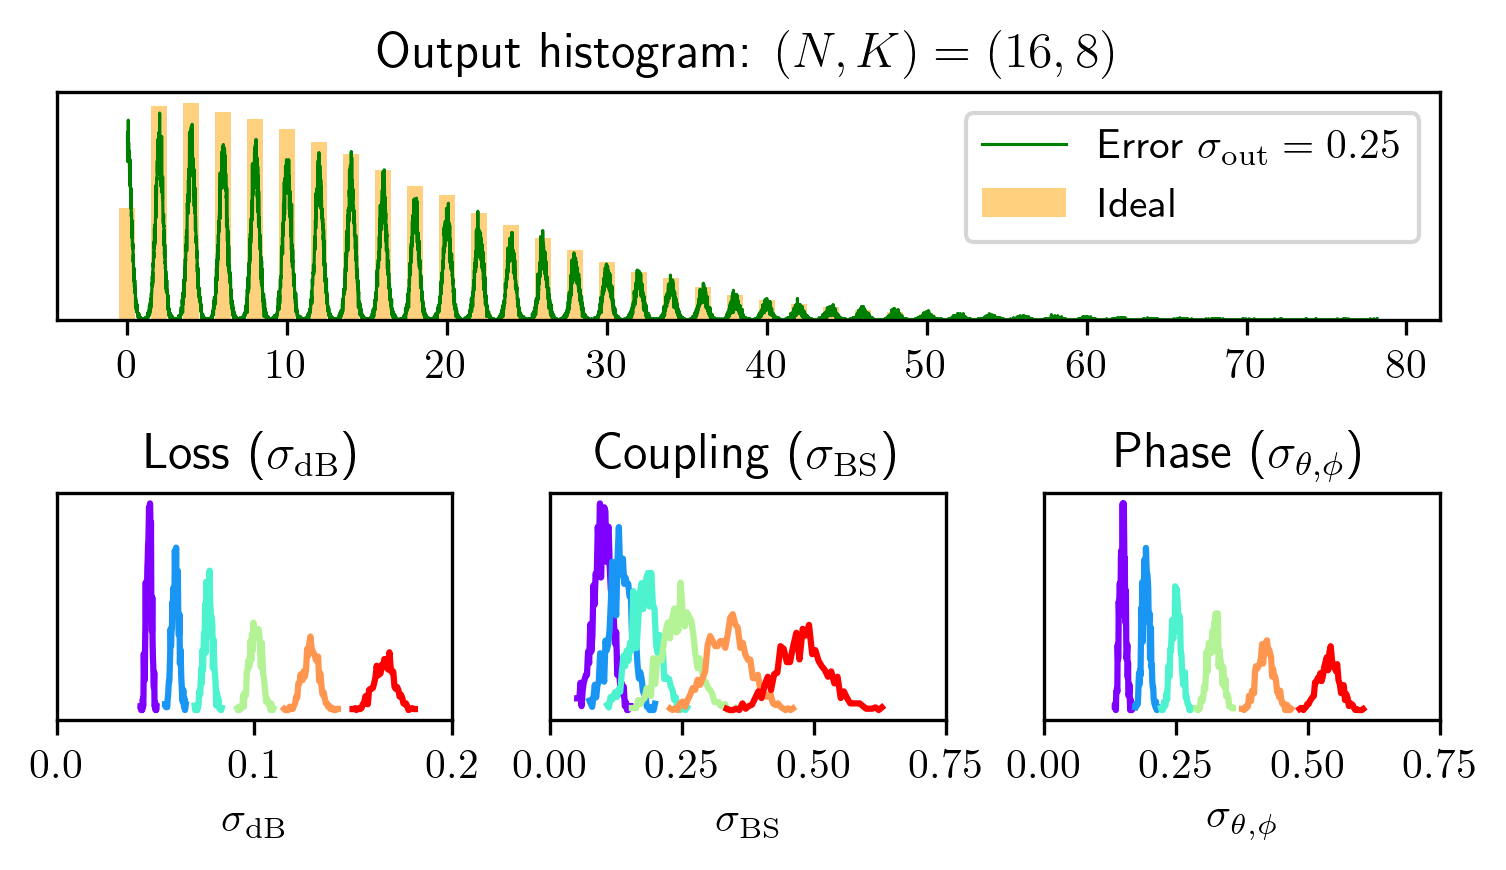

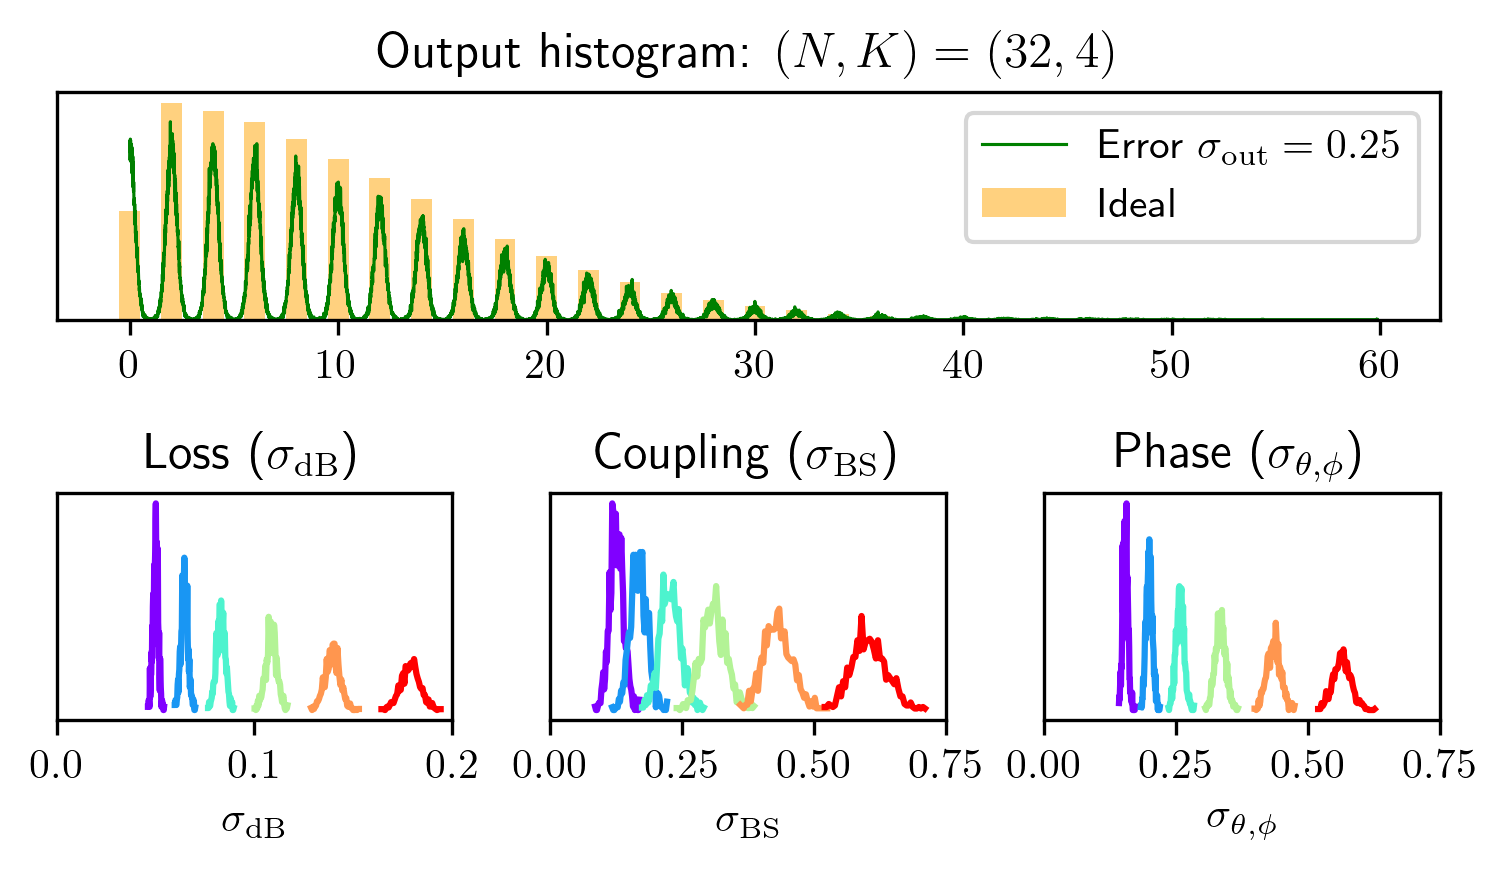

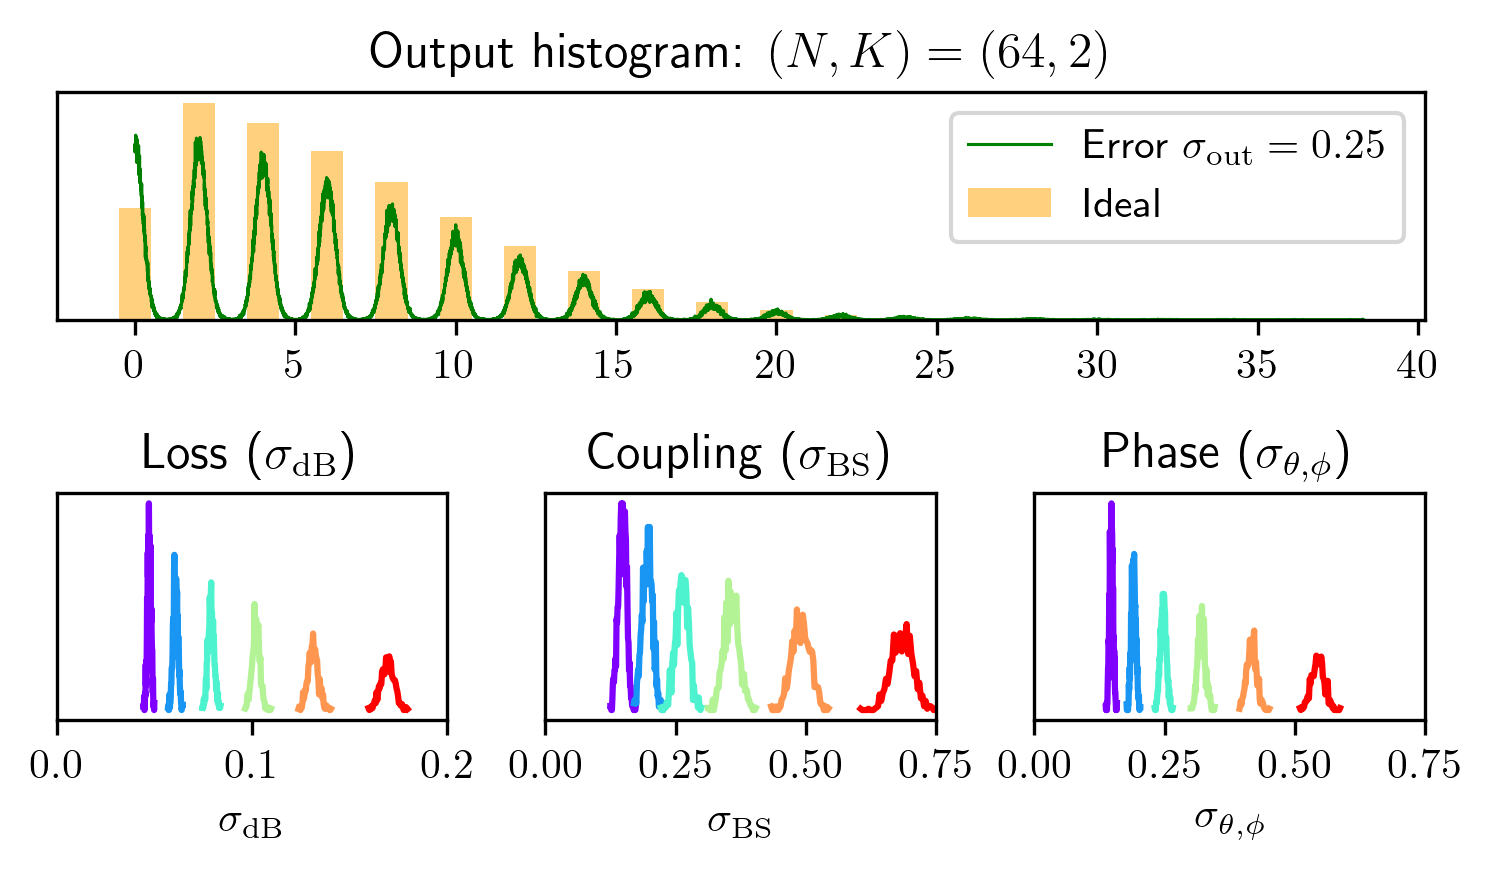

In [80]:
plot_errors(results_16_8, group_by_std=True)
plt.savefig('sim_16_8.pdf', bbox_inches=None)
plot_errors(results_32_4, group_by_std=True)
plt.savefig('sim_32_4.pdf', bbox_inches=None)
plot_errors(results_64_2, group_by_std=True)
plt.savefig('sim_64_2.pdf', bbox_inches=None)

## Generate scaling demo for bit error rate and packet error rate

In [3]:
pt = {}
rho = {}

# number of possible values (1-, 2-, and 3-bit)
ks = [2, 4, 8]

# number of inputs and outputs in the device
ns = [8, 16, 24, 32, 40, 48, 56, 64]
ns = ns[::-1]

for n in pbar(ns):
    for k in (2,3,4,5,6,7,8):
        forward = False
        while not forward:
            x = random_lh_matrix(n, n, k) @ random_lh_input(n, 10000, False)
            # plt.hist(np.abs(x.flatten()), bins=int(np.max(x)), density=True)
            hist, bins = np.histogram(np.abs(x.flatten()), bins=int(np.max(x)), density=True)
            cdf = np.cumsum(hist)
            # plt.plot(bins[:-1] / k, cdf)
            thresh = bins[np.argmin(np.abs(cdf - 0.5))]
            if np.max(cdf) == 1:
                idx = int(thresh)
                pt[(n, k)] = int(thresh)
                rho[(n, k)] = hist[idx] + hist[idx + 2]
                forward = True
rho_ = np.array([[rho[(n, k)] for n in ns[::-1]] for k in (2, 4, 8)])

  0%|          | 0/8 [00:00<?, ?it/s]

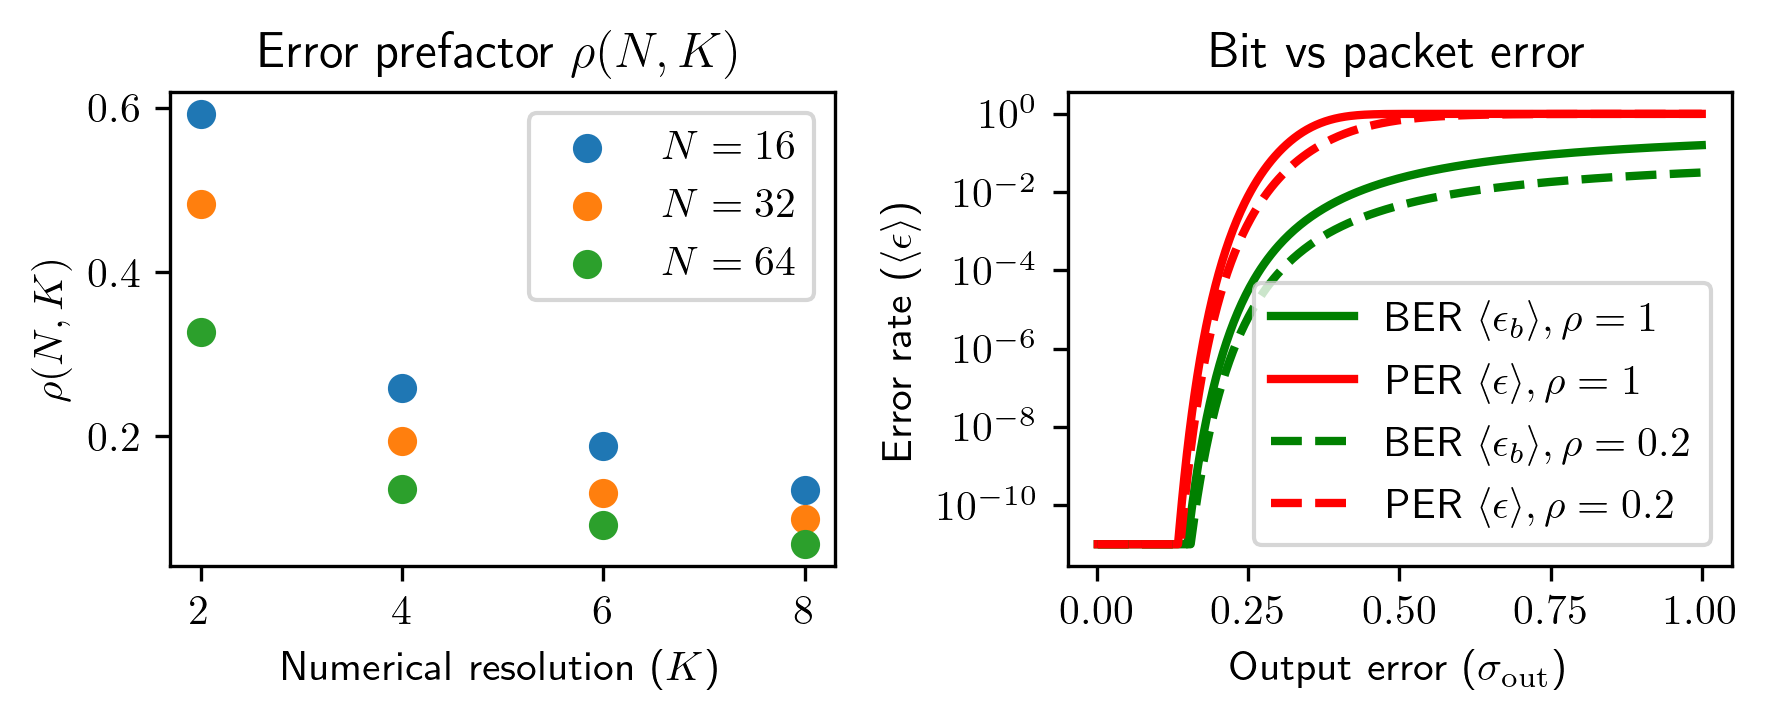

In [8]:
plt.figure(dpi=300, figsize=(6, 2.5))
plt.subplot(121)
plt.title(r'Error prefactor $\rho(N, K)$')
ks = (2,4,6,8)
plt.scatter(ks, [rho[(16, k)] for k in (2,4,6,8)])
plt.scatter(ks, [rho[(32, k)] for k in (2,4,6,8)])
plt.scatter(ks, [rho[(64, k)] for k in (2,4,6,8)])
plt.legend([f'$N = {n}$' for n in (16, 32, 64)])
plt.ylabel(r'$\rho(N, K)$')
plt.xlabel('Numerical resolution ($K$)')
# plt.ylim((0, 100))
plt.subplot(122)
per = np.maximum(10 ** (-11), 0.5 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2)))
per_r = np.maximum(10 ** (-11), 0.1 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2)))
ber = np.maximum(10 ** (-11), 1 - (1 - 0.5 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2))) ** 256)
ber_r = np.maximum(10 ** (-11), 1 - (1 - 0.1 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2))) ** 256)
plt.title('Bit vs packet error')
plt.plot(np.logspace(-3, 0, 1000), per, color='green', linewidth=2)
plt.plot(np.logspace(-3, 0, 1000), ber, color='red', linewidth=2)
plt.plot(np.logspace(-3, 0, 1000), per_r, color='green', linestyle='dashed', linewidth=2)
plt.plot(np.logspace(-3, 0, 1000), ber_r, color='red', linestyle='dashed', linewidth=2)
plt.legend([r'BER $\langle \epsilon_b\rangle, \rho = 1$',
            r'PER $\langle \epsilon\rangle, \rho = 1$',
            r'BER $\langle \epsilon_b\rangle, \rho = 0.2$',
            r'PER $\langle \epsilon\rangle, \rho = 0.2$'])
# plt.ylim((0, 1))
plt.yscale('log')
plt.gca().set_yticks((1, 10 ** -2, 10 ** -4, 10 ** -6, 10 ** -8, 10 ** -10))
plt.ylabel(r'Error rate ($\langle \epsilon \rangle$)')
plt.xlabel(r'Output error ($\sigma_{\mathrm{out}}$)')
plt.tight_layout()

plt.savefig('simulation_error_scaling.pdf')

## Plot results of the overall simulation (constant $K$, constant $\sigma$)

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_1954659/3677931893.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(np.round(1 - cbar.get_ticks(), 2))


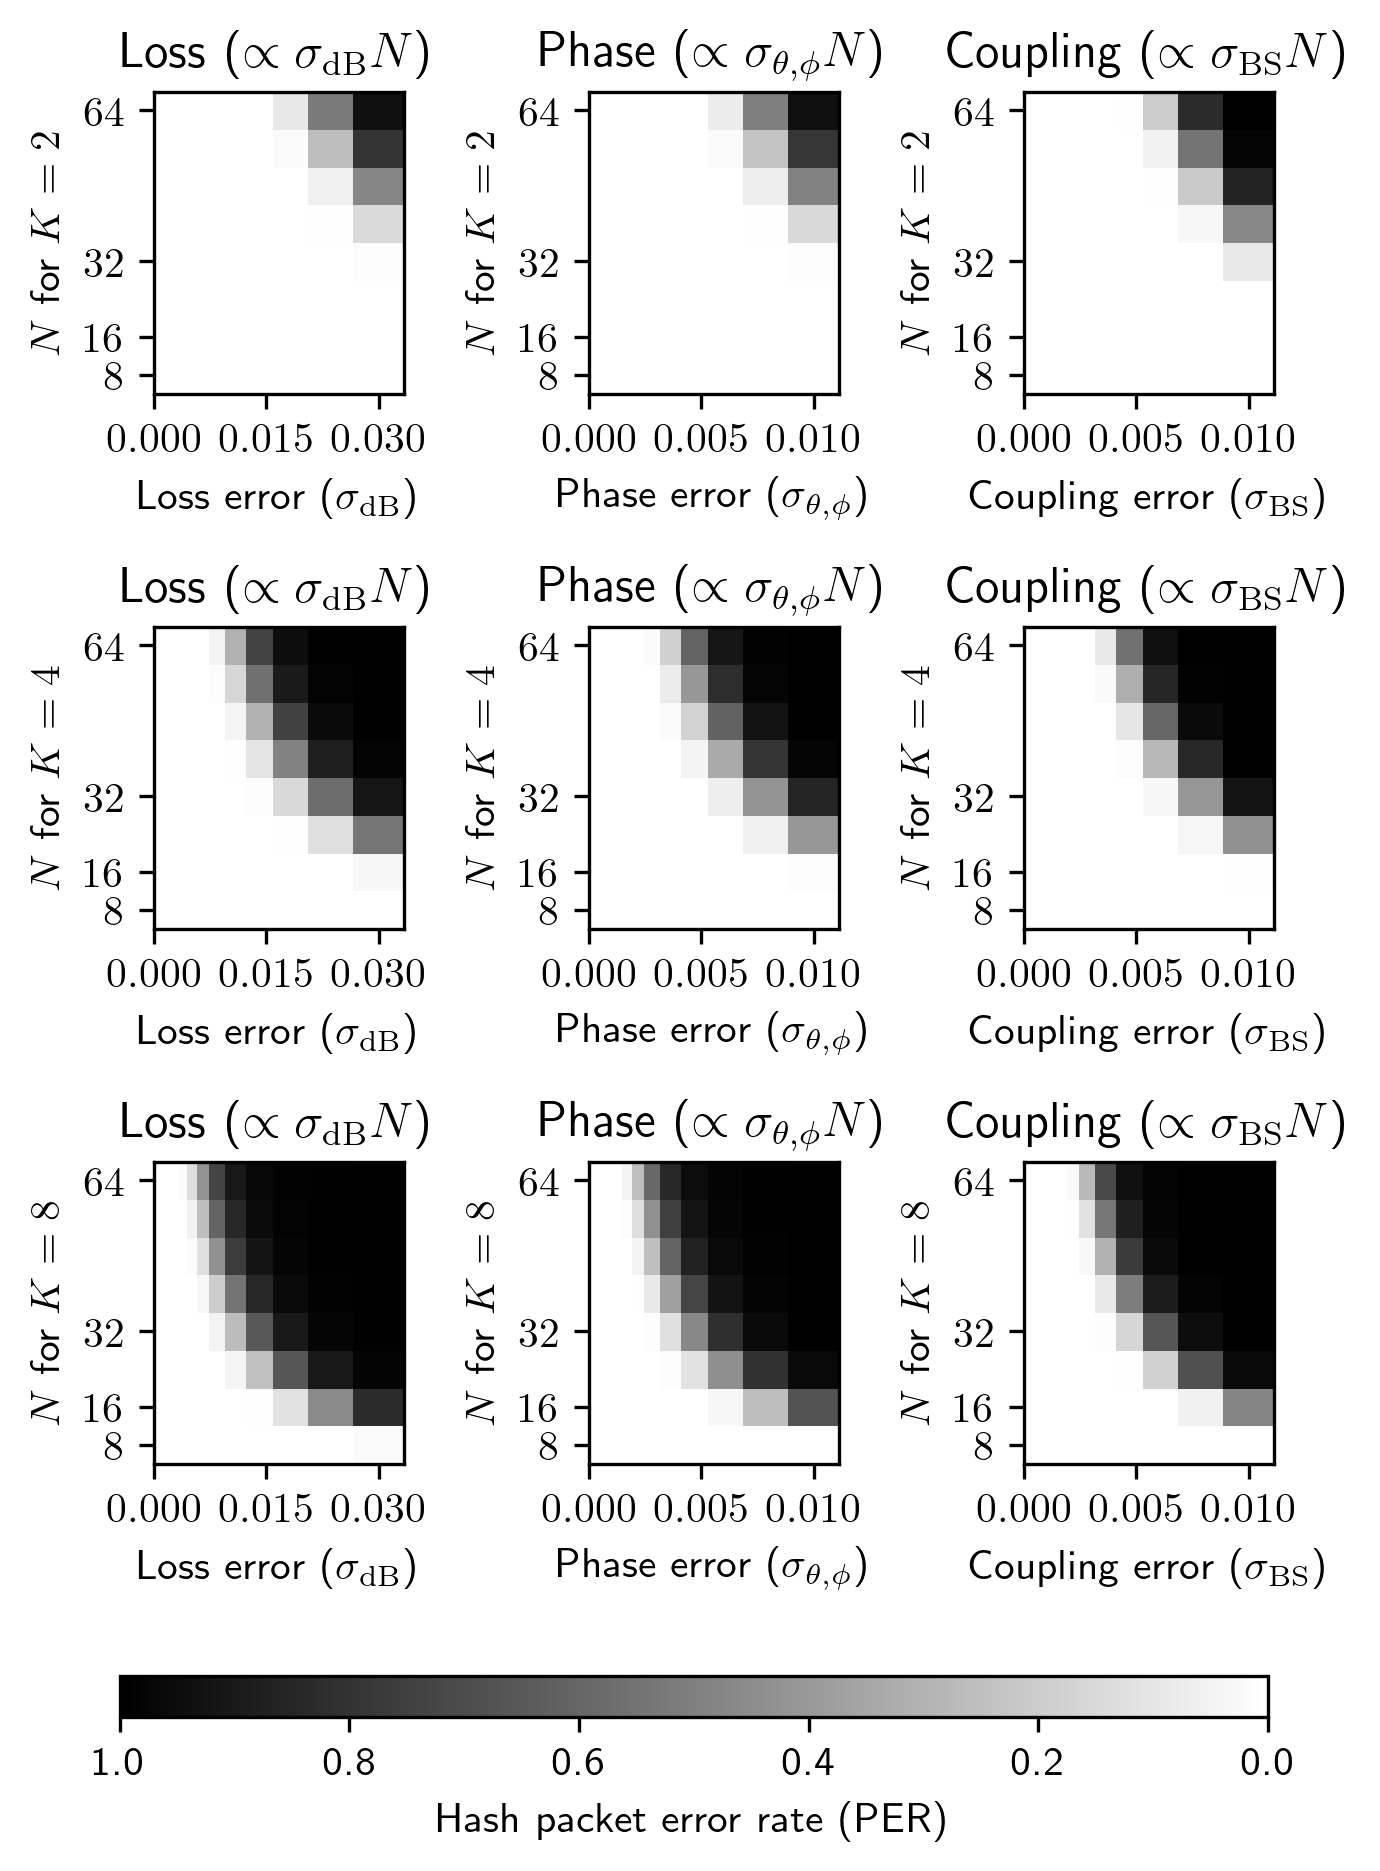

In [62]:
fig, ax = plt.subplots(3, 3, dpi=300, figsize=(4.5, 5.5))
colors = cm.rainbow(np.linspace(0, 1, 10))
errors_ = np.hstack((0, errors))

exp = 256
min_bound = 0.75 if exp == 1 else 0

for i, k in pbar(enumerate((2, 4, 8))):
    y, x = np.meshgrid(errors_[1:], ns[::-1])
    for j in pbar(range(3)):
        title = ('Loss', 'Phase', 'Coupling')[j]
        propto = ('\sigma_{\mathrm{dB}} N', '\sigma_{\\theta, \phi}N', '\sigma_{\mathrm{BS}}N')[j]
        err_label = ('\sigma_{\mathrm{dB}}', '\sigma_{\\theta, \phi}', '\sigma_{\mathrm{BS}}')[j]            
        z = (1 - 0.5  * rho_[i][:, np.newaxis] * erfc(1 / (packet_errors[(k, j)] * ((j == 0) * 2 + 1) * np.sqrt(2) + np.finfo(float).eps))) ** exp
        img = ax[i, j].pcolor(y * ((j == 0) * 2 + 1), x, z, cmap='gray', shading='auto', vmin=min_bound, vmax=1)
        img.set_clim(0, 1 - min_bound)
        ax[i, j].set_title(rf'{title} ($\propto {propto}$)')
        ax[i, j].set_xlabel(rf'{title} error (${err_label}$)')
        ax[i, j].set_ylabel(rf'$N$ for $K = {k}$')
        ax[i, j].set_yticks((8, 16, 32, 64))
        ax[i, j].set_xticks(np.array((0, 0.005, 0.01)) * ((j == 0) * 2 + 1))
plt.tight_layout()

cbar_ax = fig.add_axes([0.1, -0.05, 0.85, 0.025])
cbar = plt.colorbar(img, cax=cbar_ax, orientation='horizontal') 
cbar.ax.set_xticklabels(np.round(1 - cbar.get_ticks(), 2))
if exp == 256:
    cbar.set_label('Hash packet error rate (PER)')
    plt.savefig(f'lighthash_scalability.pdf', bbox_inches=None)
if exp == 1:
    cbar.set_label('Bit error rate (BER)')
    plt.savefig(f'lighthash_scalability_ber.pdf', bbox_inches=None)


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_1954659/1374514059.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(np.round(1 - cbar.get_ticks(), 2))


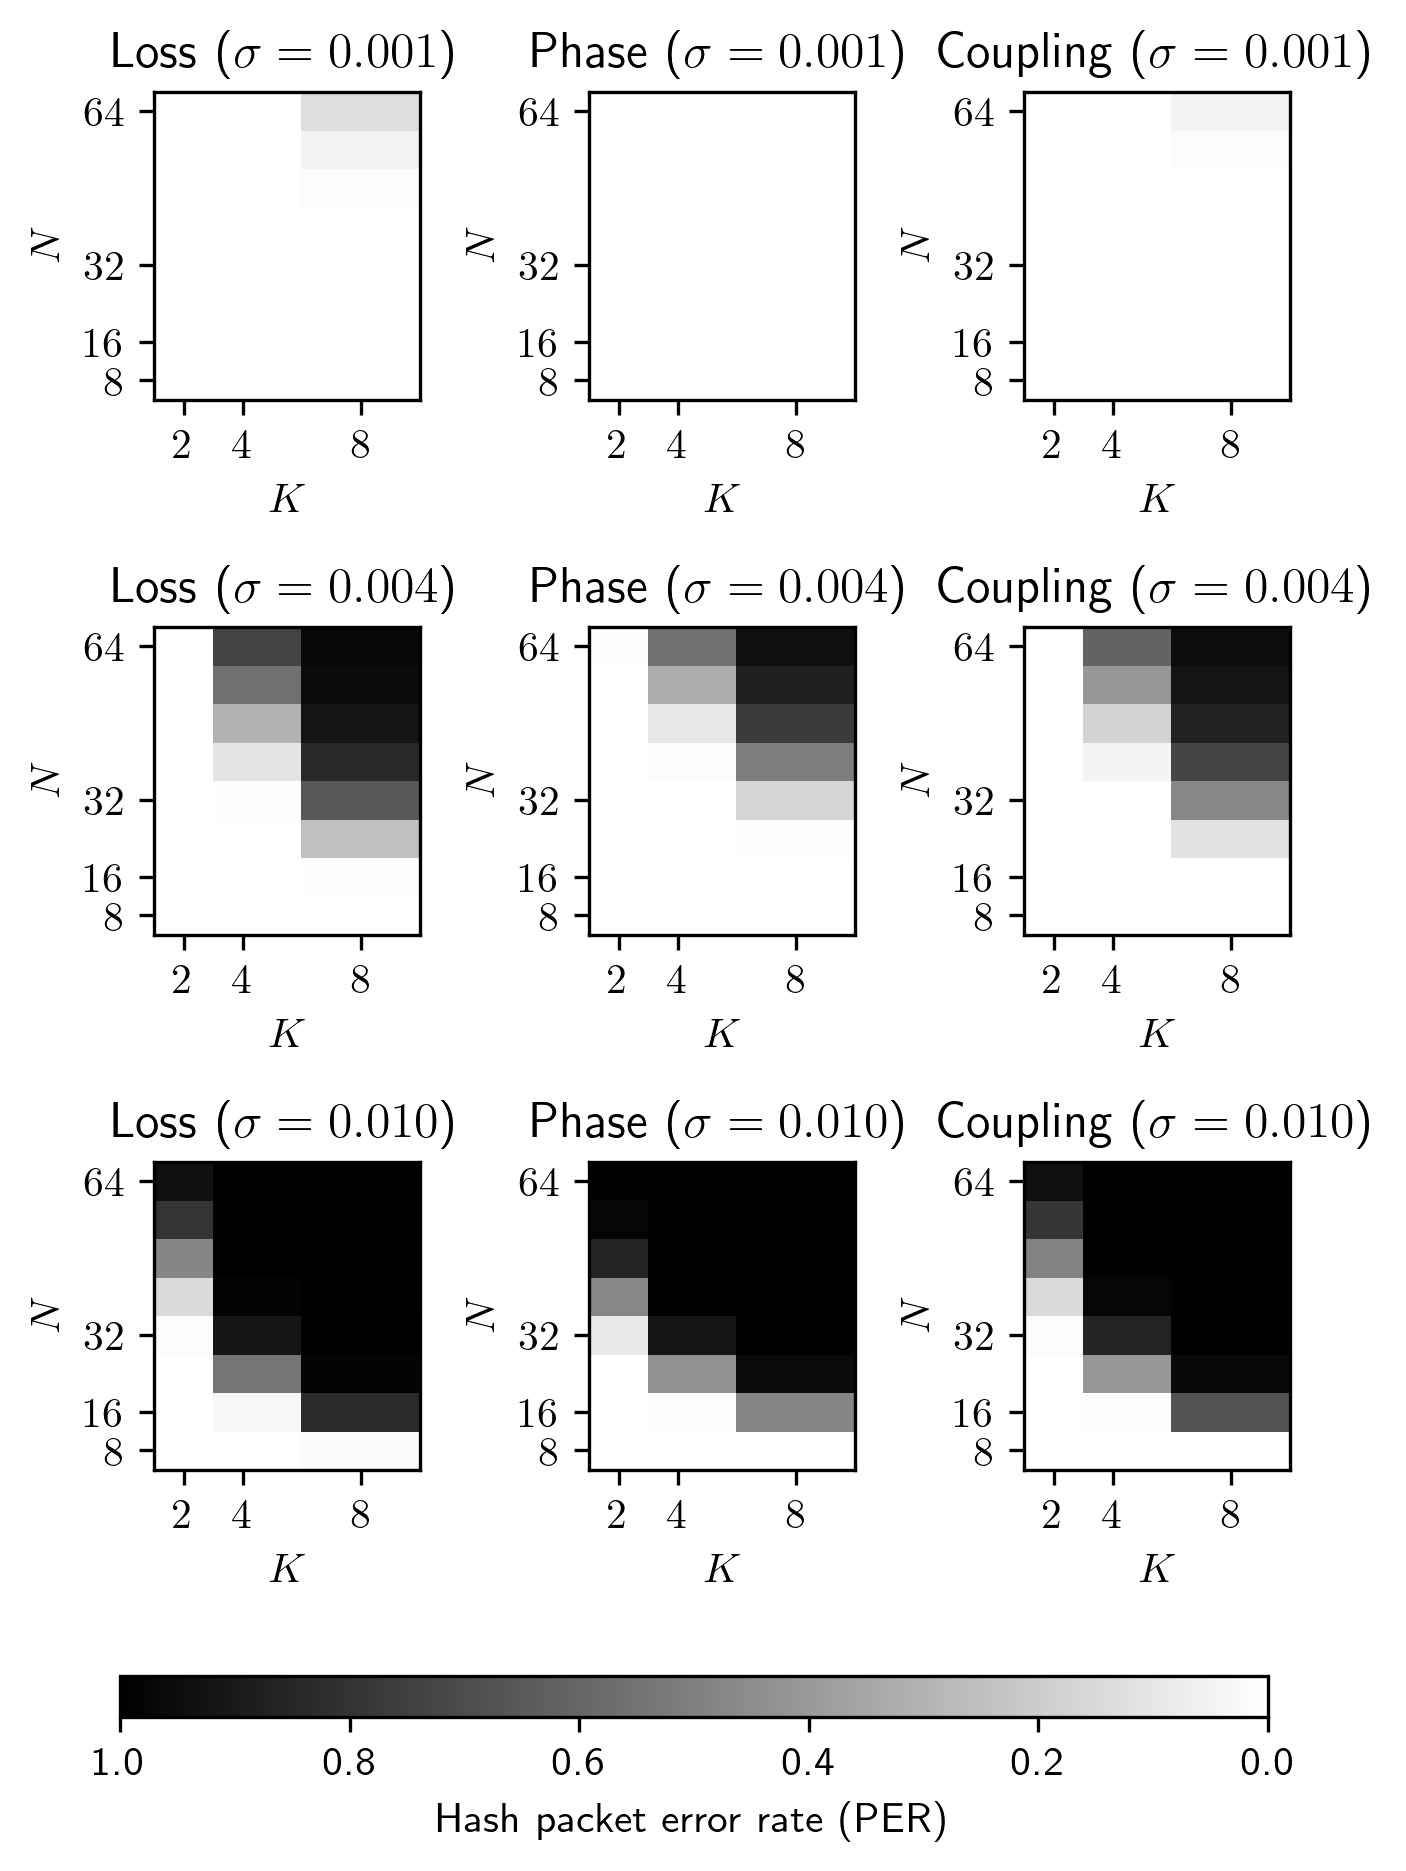

In [67]:
fig, ax = plt.subplots(3, 3, dpi=300, figsize=(4.5, 5.5))
colors = cm.rainbow(np.linspace(0, 1, 10))
errors_ = np.hstack((0, errors))

loss = np.array([packet_errors[(k, 0)] for k in (2, 4, 8)]) * 3  # artificially extend the xaxis
coupling = np.array([packet_errors[(k, 1)] for k in (2, 4, 8)])
phase = np.array([packet_errors[(k, 2)] for k in (2, 4, 8)])

min_bound = 0.25

for i, e in pbar(enumerate((2, 6, -1))):
    y, x = np.meshgrid((2, 4, 8), ns[::-1])
    for j in pbar(range(3)):
        title = ('Loss', 'Phase', 'Coupling')[j]
        propto = ('\sigma_{\mathrm{dB}} N', '\sigma_{\\theta, \phi}N', '\sigma_{\mathrm{BS}}N')[j]
        err_label = ('\sigma_{\mathrm{dB}}', '\sigma_{\\theta, \phi}', '\sigma_{\mathrm{BS}}')[j]
        err = (loss, phase, coupling)[j][..., e]
        z = (1 - 0.5 * rho_ * erfc(1 / (err * np.sqrt(2) + np.finfo(float).eps))) ** exp
        img = ax[i, j].pcolor(y, x, z.T, cmap='gray', shading='auto', vmin=0, vmax=1)
        img.set_clim(0, 1)
        ax[i, j].set_title(rf'{title} ($\sigma = {errors_[e]:.3f}$)')
        ax[i, j].set_xlabel(rf'$K$')
        ax[i, j].set_ylabel(rf'$N$')
        ax[i, j].set_yticks((8, 16, 32, 64))
        ax[i, j].set_xticks(np.array((2, 4, 8)))
plt.tight_layout()

cbar_ax = fig.add_axes([0.1, -0.05, 0.85, 0.025])
cbar = plt.colorbar(img, cax=cbar_ax, orientation='horizontal') 
cbar.ax.set_xticklabels(np.round(1 - cbar.get_ticks(), 2))
if exp == 256:
    cbar.set_label('Hash packet error rate (PER)')
    plt.savefig(f'lighthash_scalability_k.pdf', bbox_inches=None)
if exp == 1:
    cbar.set_label('Bit error rate (BER)')
    plt.savefig(f'lighthash_scalability_ber_k.pdf', bbox_inches=None)


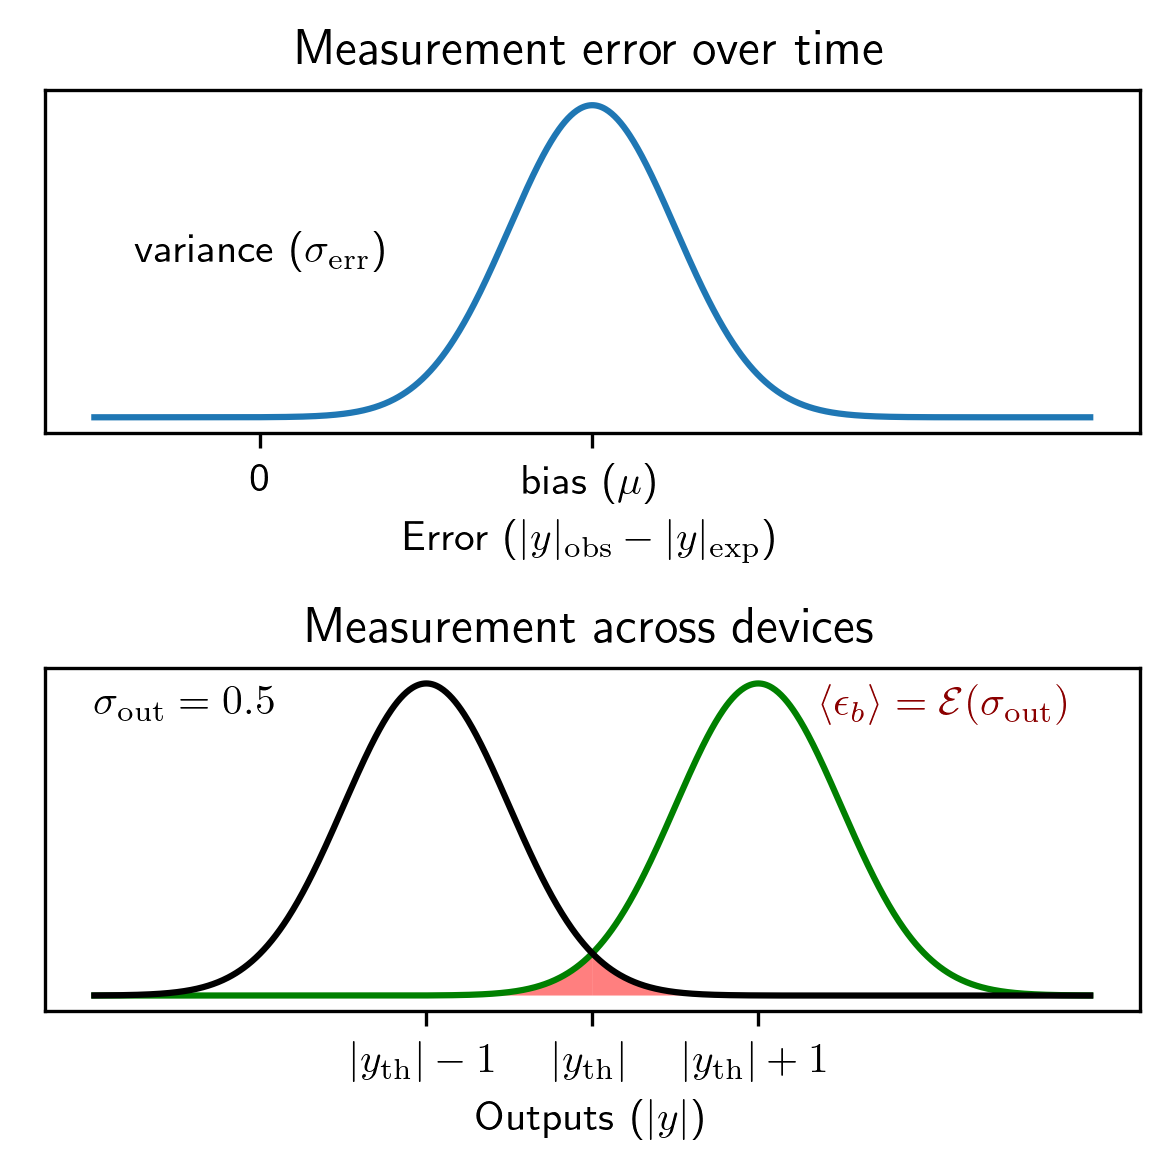

In [12]:
plt.figure(dpi=300, figsize=(4, 4))

x = np.linspace(-1, 5, 1000)
plt.subplot(211)
plt.plot(x, np.exp(-(x - 2) ** 2 / 2 * 4))
plt.text(0, 0.5, r'variance ($\sigma_{\mathrm{err}}$)', ha='center')
plt.title('Measurement error over time')
plt.xticks([0, 2])
plt.gca().set_xticklabels([0, r'bias ($\mu$)'])
plt.xlabel('Error ($|y|_{\mathrm{obs}} - |y|_{\mathrm{exp}}$)')
plt.gca().get_yaxis().set_visible(False)
plt.subplot(212)
x = np.linspace(-3, 3, 1000)
plt.plot(x, np.exp(-(x - 1) ** 2 / 2 * 4), color='green')
plt.plot(x, np.exp(-(x + 1) ** 2 / 2 * 4), color='black')
plt.fill_between(x[500:], np.exp(-(x[500:] + 1) ** 2 / 2 * 4), color='red', edgecolor='none', alpha=0.5)
plt.fill_between(x[:501], np.exp(-(x[:501] - 1) ** 2 / 2 * 4), color='red', edgecolor='none', alpha=0.5)
plt.text(-3, 0.9, r'$\sigma_{\mathrm{out}} = 0.5$')
plt.text(1.38, 0.9, r'$\langle\epsilon_{b}\rangle = \mathcal{E}(\sigma_{\mathrm{out}})$', color='darkred')
plt.xticks([-1, 0, 1])
plt.gca().get_yaxis().set_visible(False)
plt.gca().set_xticklabels([r'$|y_{\mathrm{th}}| - 1$', r'$|y_{\mathrm{th}}|$', r'$|y_{\mathrm{th}}| + 1$'])
plt.title('Measurement across devices')
plt.xlabel('Outputs ($|y|$)')
plt.tight_layout()
plt.savefig('measurement_concept.pdf')

## Mining emulation

Here, we provide some simple implementations of the LightHash emulator (refer to phox package to see the full code or the paper to see the pseudocode used here).

In [3]:
from phox.apps.opow import LHMerkleTree, LHBlock, generate_random_lh_transactions

n_segments = 32 # number of segments used in the transaction building, used for synthetic transaction generation.
difficulty = 10 # tune this to change the difficulty and increase the solve time.


transaction_data = [generate_random_lh_transactions(['Alice', 'Bob', 'Carole', 'Dave', 'Earl', 'Fannie',
                                                    'George', 'Howard', 'Isabelle', 'Joseph', 'Karen',
                                                    'Laura', 'Madison', 'Nicholas', 'Oliver', 'Patrick',
                                                    'Quentin', 'Rose', 'Stephen', 'Timothy', 'Uma', 'Victor',
                                                    'Winnie', 'Xavier', 'Yvonne', 'Zoe']) for _ in range(n_segments)]

data = LHMerkleTree(transaction_data)

blocks = []

# genesis block
blocks.append(LHBlock(data, difficulty=10))

# rest of the blocks in the chain get added after genesis block referring to previous block.
# while True:
#     new_block = LHBlock(data, last_block=blocks[-1], difficulty=10)

## Systematic error model data generation and fitting (updated)

In [6]:
from simphox.circuit import rectangular
from simphox.utils import random_unitary
from jax import jit
import jax
import numpy as np
import jax.numpy as jnp
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

jax.config.update('jax_platform_name', 'cpu')  # change to cpu if not using gpu (slower!)
jax.config.update("jax_enable_x64", False)
jax.devices()

ns = (np.arange(16) + 1) * 8  # 8 to 128
# number of possible values (1-, 2-, and 3-bit)
ks = [3, 5, 9, 17]

In [1]:
from tqdm.notebook import tqdm as pbar
from simphox.circuit import psvd
import xarray as xr
import numpy as np

# the possible errors
errors = np.linspace(0, 0.01, 21)
# complex standard deviation works as follows:
def complex_std(x):
    return np.sqrt(np.std(np.real(x)) ** 2 + np.std(np.imag(x)) ** 2)

def random_lh_matrix(n_vecs, n, num_vals, normed=False):
    offset = num_vals - 1
    v = (2 * np.random.randint(num_vals, size=(n_vecs, n)) - offset)
    return v / np.sqrt(np.sum(v ** 2, axis=1)[:, np.newaxis]) if normed else v


def random_lh_input(n, n_trials, normed=True):
    v = (2 * np.random.randint(2, size=(n, n_trials)) - 1)
    return v / np.sqrt(n) if normed else v

error_weights = [
    [0, 0, 3], # bs_error, phase_error, loss_error
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 3],
    [1, 1, 0]
]

num_matrix_trials = 20
num_error_trials_scale = 10

GENERATE_DATA = False

if GENERATE_DATA:
    meshes = {
        n: rectangular(random_unitary(n))
        for n in ns
    }

    matrix_fn = {
        n: jit(meshes[n].matrix_fn(use_jax=True))
        for n in ns
    }

    def apply_error(mesh, bs_err=0, phase_err=0, loss_err=0):
        return matrix_fn[mesh.n](
            params=(
                mesh.thetas + phase_err * np.random.randn(*mesh.thetas.shape),
                mesh.phis + phase_err * np.random.randn(*mesh.phis.shape),
                mesh.gammas + phase_err * np.random.randn(*mesh.gammas.shape)
            ),
            bs_errors=np.vstack([bs_err * np.random.randn(*mesh.bs_errors[:, 0].shape)] * 2).T,
            loss_errors=loss_err * np.random.randn(*mesh.all_losses.shape)
        )
    mat_errors = {}
    for n in ns:
        errors_n_k = []
        for k in ks:
            print(f'n = {n}, k = {k}')
            errors_n_k_i = []
            for _ in pbar(range(20)):
                q_sim = []
                q = random_lh_matrix(n, n, num_vals=k)
                l, d, r = psvd(q)
                for j, ew in enumerate(error_weights):
                    w1, w2, w3 = ew
                    q_sim.append(np.array(
                        [[apply_error(l, bs_err=e*w1, phase_err=e*w2, loss_err=e*w3) * d @ apply_error(r, bs_err=e*w1, phase_err=e*w2, loss_err=e*w3)
                         for i in range(num_error_trials_scale * 128 // n)] for e in errors]
                    ))
                q_sim = np.array(q_sim)
                inputs = random_lh_input(n, 1000, normed=False)
                errors_n_k_i.append(xr.DataArray(
                    data=np.abs(q_sim @ inputs) - np.abs(q[np.newaxis, np.newaxis, np.newaxis] @ inputs),
                    dims=['error_type', 'error_scale', 'error_trial', 'index', 'num_inputs']
                ))
            errors_n_k.append(xr.concat(errors_n_k_i, 'matrix_trial').std(['matrix_trial', 'error_trial', 'num_inputs', 'index']))
        mat_errors[n] = xr.concat(errors_n_k, 'k')
        mat_errors[n]['k'] = ks
    mat_errors = xr.concat([mat_errors[n] for n in ns], 'n')
    mat_errors['n'] = ns
    mat_errors['error_type'] = ['loss_var', 'phase', 'coupling', 'all', 'phase_coupling']
    mat_errors['error_scale'] = np.linspace(0, 0.01, 21)
    mat_errors = mat_errors.transpose('n', 'k', 'error_scale', 'error_type')
    mat_errors.to_netcdf('crypto_sim.nc')
else:
    mat_errors = xr.open_dataarray('crypto_sim.nc')

In [16]:
from scipy.optimize import curve_fit
import jax.numpy as jnp

mat_errors = mat_errors.transpose('n', 'k', 'error_scale', 'error_type')
mat_errors_fit = mat_errors[:, :, 1:]
n, k, s, _ = xr.broadcast(mat_errors_fit.n, mat_errors_fit.k, mat_errors_fit.error_scale, mat_errors_fit.error_type) 
n, k, s = n.data, k.data, s.data
w = np.array(error_weights).T
mat = jnp.array(np.stack([np.ones_like(n), s, n * s], -1).data)

def error_model(p):
    v = jnp.abs(jnp.reshape(p, (-1, 6))) @ jnp.array([
        w[0] ** 2, w[1] ** 2, w[2] ** 2,     # variance
        w[0] * w[1], w[1] * w[2], w[2] * w[0]# covariance
    ])
    return (n * k * s * jnp.sqrt(jnp.sum(mat * v.T, axis=-1))).ravel()

def error_model_scipy(x, *p):
    return error_model(np.array(p))

In [19]:
b, v = curve_fit(
    error_model_scipy,
    None,
    mat_errors_fit.data.ravel(),
    p0=np.ones(mat.shape[-1] * 6)
)

np.mean(np.abs(((error_model(b) - mat_errors_fit.data.ravel()) / mat_errors_fit.data.ravel())))

/home/exx/miniconda3/envs/phox/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.031164918

/tmp/ipykernel_1766401/1022749700.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['', 'coupling', 'phase', 'loss'])
/tmp/ipykernel_1766401/1022749700.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['', 'coupling', 'phase', 'loss'])


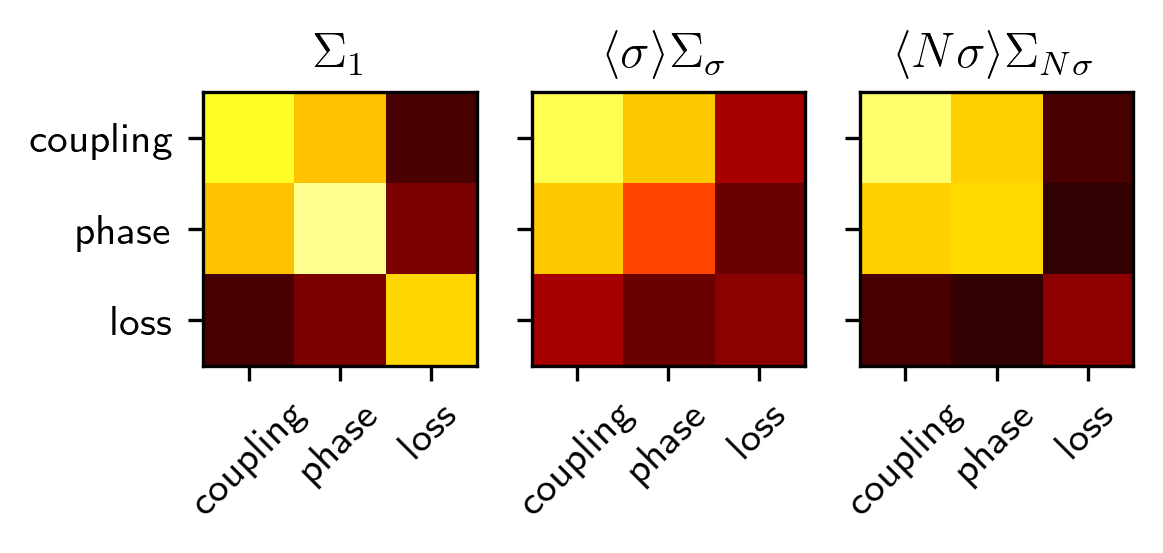

In [20]:
b_rescaled = np.abs(b.reshape((-1, 6)))
b_rescaled[1] *= s.mean()
b_rescaled[2] *= (n * s).mean()
sigmas = np.log10(np.array([[[b_rescaled[i, 0], b_rescaled[i, 3] / 2, b_rescaled[i, 4] / 2],
           [b_rescaled[i, 3] / 2, b_rescaled[i, 1], b_rescaled[i, 5] / 2],
           [b_rescaled[i, 4] / 2, b_rescaled[i, 5] / 2, b_rescaled[i, 2]]] for i in range(3)]))
plt.figure(dpi=300, figsize=(4, 2))
plt.subplot(131)
plt.imshow(sigmas[0], cmap='hot', clim=(-7, 0))
plt.title('$\Sigma_1$')
plt.gca().set_yticklabels(['', 'coupling', 'phase', 'loss'])
plt.gca().set_xticks([0, 1, 2])
plt.gca().set_xticklabels(['coupling', 'phase', 'loss'], rotation=45)
plt.subplot(132)
plt.imshow(sigmas[1], cmap='hot', clim=(-7, 0))
plt.title('$\langle\sigma\\rangle\Sigma_\sigma$')
plt.gca().set_xticklabels(['', 'coupling', 'phase', 'loss'])
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.gca().set_xticks([0, 1, 2])
plt.gca().set_xticklabels(['coupling', 'phase', 'loss'], rotation=45)
plt.subplot(133)
plt.imshow(sigmas[2], cmap='hot', clim=(-7, 0))
plt.title('$\langle N \sigma \\rangle\Sigma_{N\sigma}$')
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.gca().set_xticks([0, 1, 2])
plt.gca().set_xticklabels(['coupling', 'phase', 'loss'], rotation=45)
# plt.colorbar()
plt.savefig('error_model_coeffs.pdf')

## Energy tradeoff analysis

In [7]:
pt = {}
rho = {}
cdfs = {}

for n in pbar(ns):
    for k in ks:
        forward = False
        while not forward:
            x = random_lh_matrix(n, n, k) @ random_lh_input(n, 10000, False)
            # plt.hist(np.abs(x.flatten()), bins=int(np.max(x)), density=True)
            hist, bins = np.histogram(np.abs(x.flatten()), bins=int(np.max(x)), density=True)
            cdf = np.cumsum(hist)
            cdfs[(n, k)] = cdf
            # plt.plot(bins[:-1] / k, cdf)
            thresh = bins[np.argmin(np.abs(cdf - 0.5))]
            if np.max(cdf) == 1:
                idx = int(thresh)
                pt[(n, k)] = int(thresh)
                rho[(n, k)] = hist[idx] + hist[idx + 2]
                forward = True

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
def electrical_power(responsivity, average_received_power_amps, gain):
    return gain ** 2 * responsivity ** 2 * average_received_power_amps ** 2
    
def thermal_noise(sampling_frequency_hz, feedback_resistance, kt, noise_figure):
    return 4 * kt / feedback_resistance * sampling_frequency_hz * noise_figure
    
def shot_noise(responsivity, average_received_power_amps, gain, impact_ionization_ka,
               sampling_frequency_hz, q, dark_current):
    fa = impact_ionization_ka * gain + (1 - impact_ionization_ka) * (2 - 1 / gain)
    return 4 * q * gain ** 2 * fa * (responsivity * average_received_power_amps + dark_current) * sampling_frequency_hz

def noise_evaluator(responsivity=0.85,
                    average_input_power_watts=700e-6,
                    loss_per_layer=0.1,
                    gain=10,
                    impact_ionization_ka=0.05,
                    sampling_frequency_hz=1e9,
                    feedback_resistance=500,
                    kt=1.38e-23 * 293.15,
                    q=1.6e-19,
                    dark_current=40e-9,
                    noise_figure=1.5,
                    tia_gain_kohm=10 ** 4.6, #Ohm
                    noise_std_comparator=1.3e-3, #V
                    noise_std_tia=0.32e-6, #A
                    n=64,
                    include_thermal=True):
    average_received_power_watts = average_input_power_watts / (4 * 10 ** (0.02 * n))
    signal = electrical_power(responsivity, average_received_power_watts, gain)
    noise_th = thermal_noise(sampling_frequency_hz, feedback_resistance, kt, noise_figure) if include_thermal else 0
    noise_shot = shot_noise(responsivity, average_received_power_watts, gain, impact_ionization_ka,
               sampling_frequency_hz, q, dark_current)
    noise_electrical = noise_std_comparator ** 2 / tia_gain_kohm ** 2 + noise_std_tia ** 2
    return {
        'signal': signal,
        'thermal_noise': noise_th,
        'shot_noise': noise_shot,
        'electrical_noise': noise_electrical,
        'snr': 10 * np.log10(signal / (noise_th + noise_shot + noise_electrical)),
        'std_fraction': np.sqrt((noise_th + noise_shot + noise_electrical) / signal),
    }

In [10]:
from scipy.special import erfc

ps = np.linspace(1, 1000, 901) * 1e-6
stds = [[noise_evaluator(n=n, average_input_power_watts=p)['std_fraction'] for n in ns] for p in ps]

pt_ = np.array([[pt[(n, k)] for n in ns] for k in ks])
rho_ = np.array([[rho[(n, k)] for n in ns] for k in ks])

error = xr.DataArray(
    data=np.array(stds).T[None, :] * pt_[..., None],
    dims=['$K$', '$N$', '$P_{\mathrm{node}}$ (mW)'],
    coords={
        '$K$': ks,
        '$N$': ns,
        '$P_{\mathrm{node}}$ (mW)': ps * 1000
    }
)

per = xr.DataArray(
    data=1 - (1 - rho_[:, :, None] * erfc(1 / np.array(stds).T[None, :] / pt_[..., None] * np.sqrt(2))) ** 256,
    dims=['$K$', '$N$', '$P_{\mathrm{mode}}$ (mW)'],
    coords={
        '$K$': ks,
        '$N$': ns,
        '$P_{\mathrm{mode}}$ (mW)': ps * 1000
    }
)

per_scaled = (-np.log10(per + np.finfo(float).eps))

per_systematic = xr.DataArray(
    data=1 - (1 - rho_[:, :, None, None] * erfc(1 / mat_errors.transpose('k', 'n', ...) / np.sqrt(2))) ** 256,
    dims=['$K$', '$N$', '$\sigma$', 'error_type'],
    coords={
        '$K$': ks,
        '$N$': ns,
        '$\sigma$': errors,
        'error_type': mat_errors.error_type
    }
)

per_systematic_scaled = (-np.log10(per_systematic + np.finfo(float).eps))

e_tia = 145
e_comp = 40

energy_per_op = xr.DataArray(
    data=((ps * 1e6 + e_tia + e_comp)[None, :] / ns[:, None] ),
    dims=['$N$', '$P_{\mathrm{node}}$'],
    coords={
        '$N$': ns,
        '$P_{\mathrm{node}}$': ps * 1000
    }
)

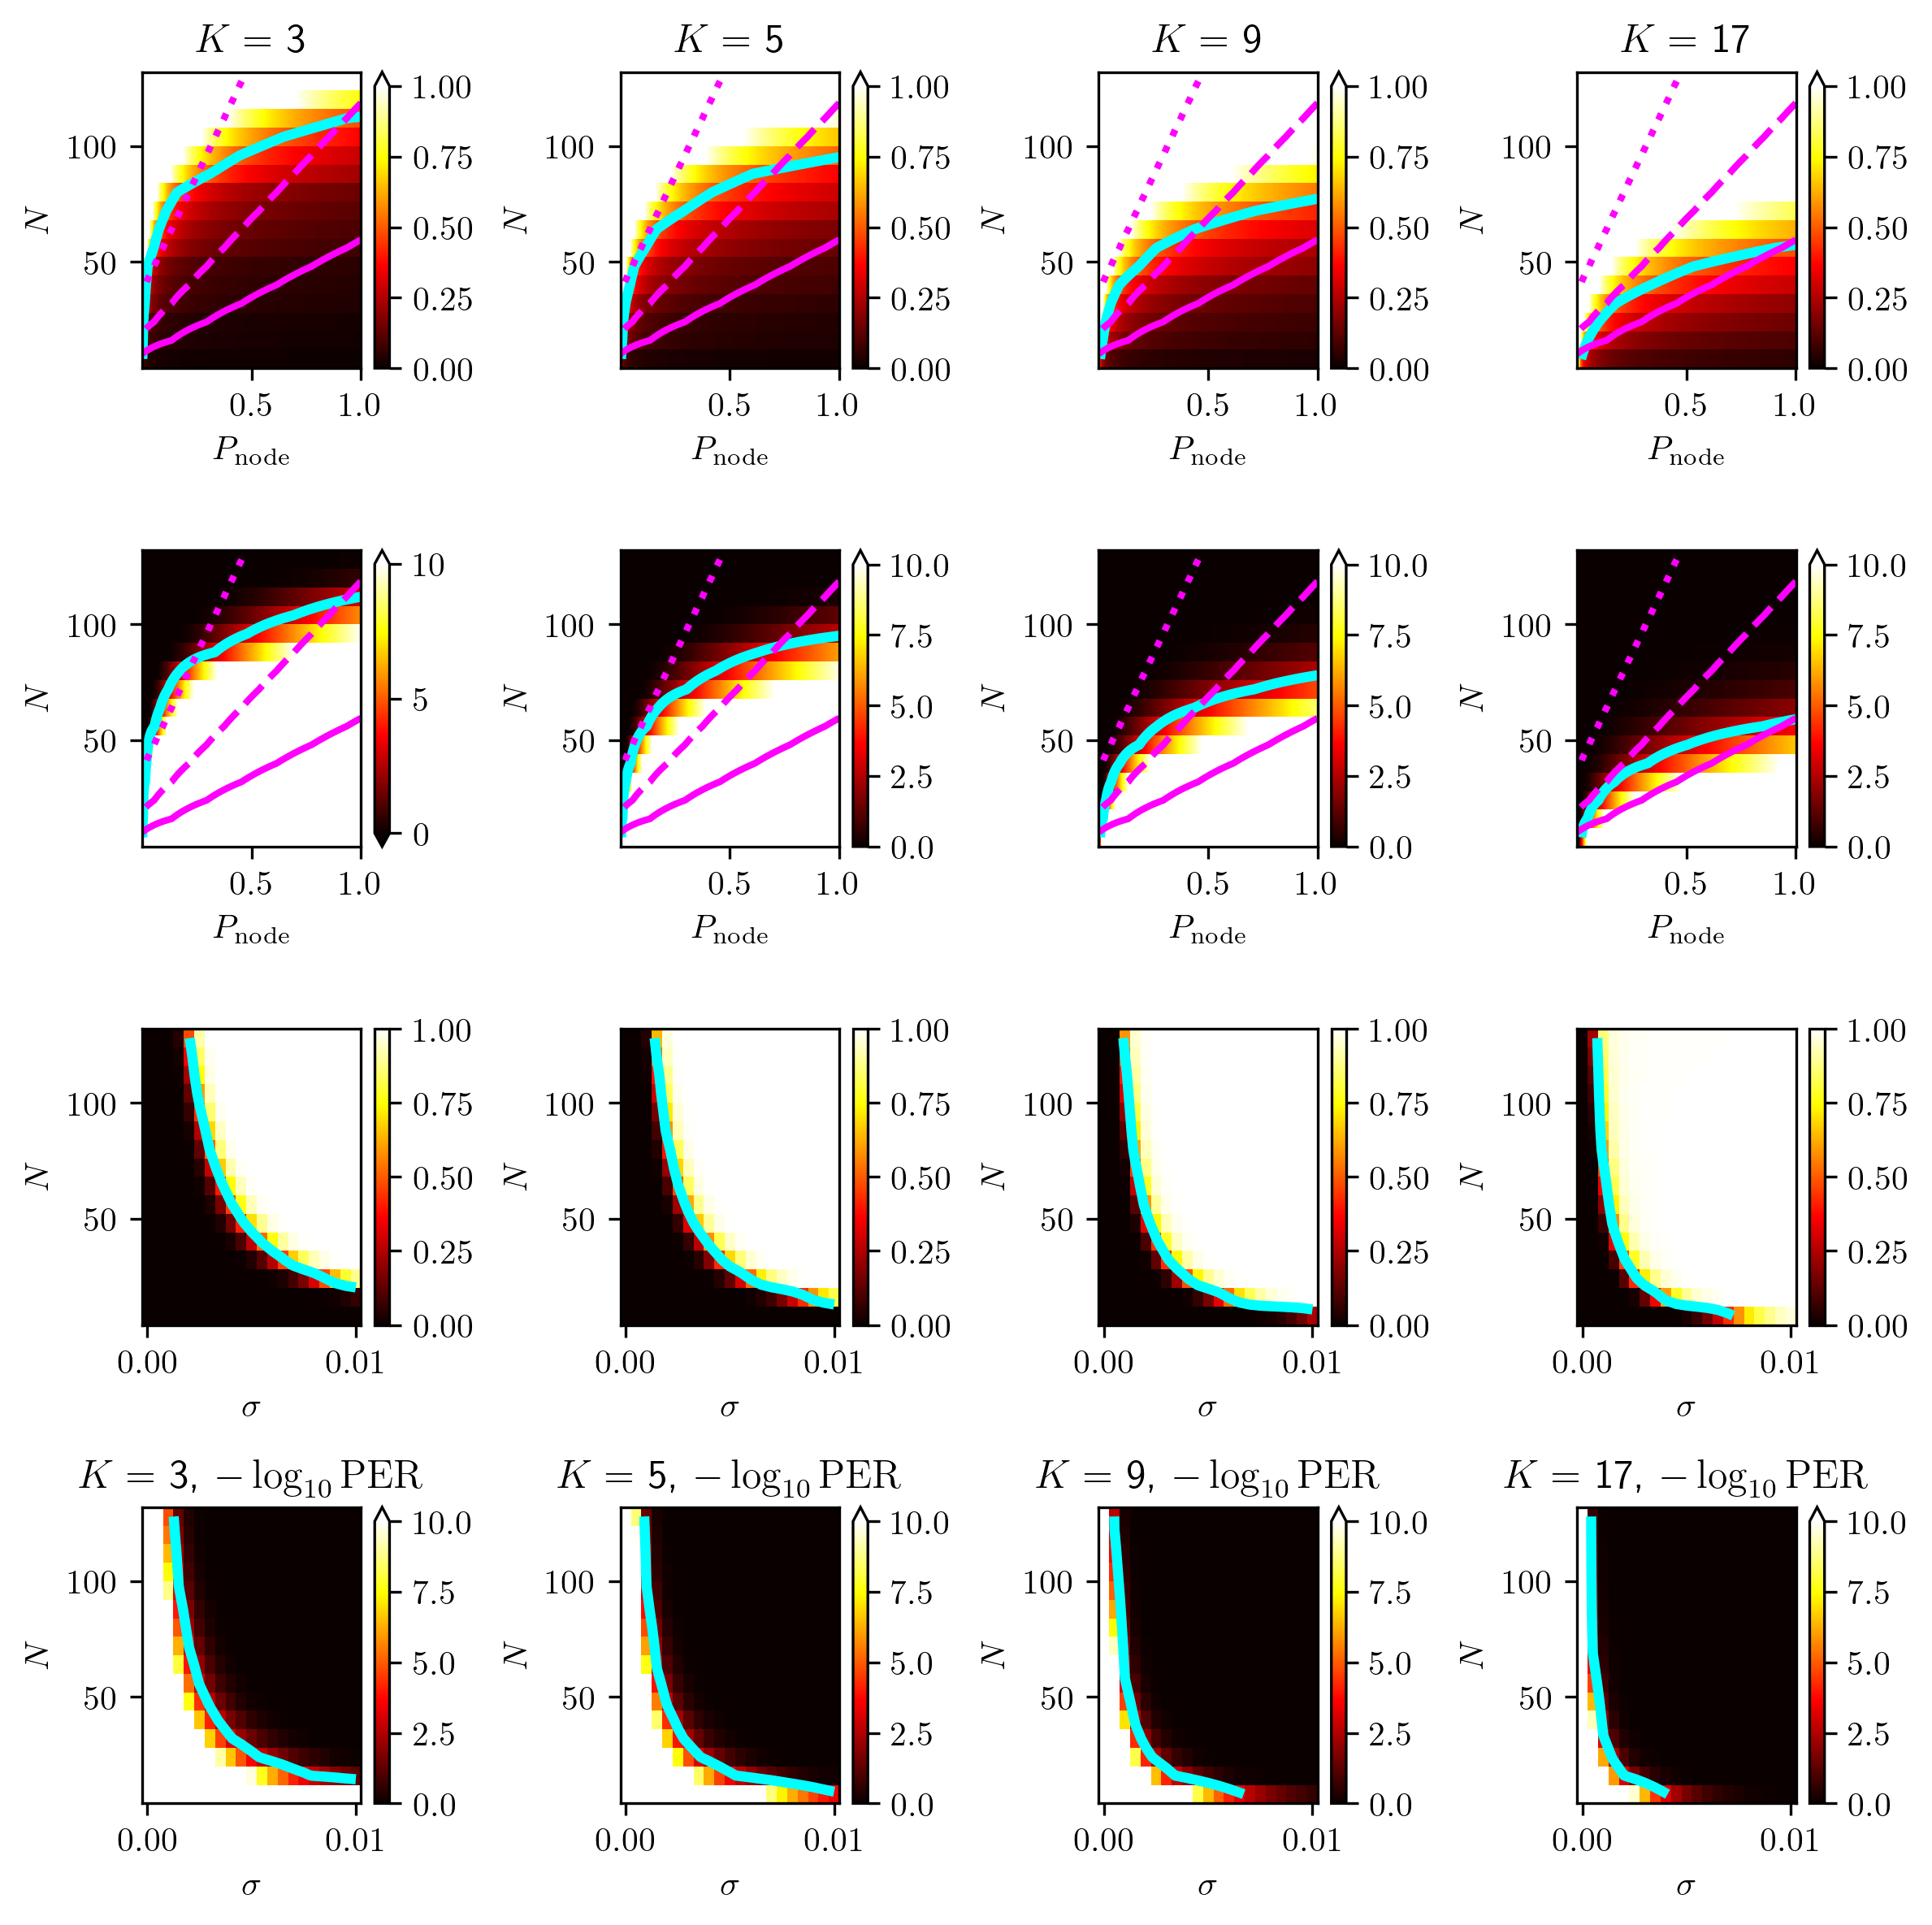

In [14]:
plt.figure(figsize=(8, 8), dpi=300)
for i in range(4):
    plt.subplot(4, 4, 1 + i)
    error[i].plot(vmin=0, vmax=1, cmap='hot')
    error[i].plot.contour(levels=[0.5], colors='cyan', linewidths=3)
    energy_per_op.plot.contour(levels=[5], colors='magenta', linewidths=2, linestyles='dotted')
    energy_per_op.plot.contour(levels=[10], colors='magenta', linewidths=2, linestyles='dashed')
    energy_per_op.plot.contour(levels=[20], colors='magenta', linewidths=2)
    plt.title(f'$K = $ {ks[i]}')
    plt.subplot(4, 4, 5 + i)
    per_scaled[i].plot(vmin=0, vmax=10, cmap='hot')
    per_scaled[i].plot.contour(levels=[3], colors='cyan', linewidths=3)
    energy_per_op.plot.contour(levels=[5], colors='magenta', linewidths=2, linestyles='dotted')
    energy_per_op.plot.contour(levels=[10], colors='magenta', linewidths=2, linestyles='dashed')
    energy_per_op.plot.contour(levels=[20], colors='magenta', linewidths=2)
    # plt.title(f'$K = $ {ks[i]}, $-\log_{{10}} \mathrm{{PER}}$')
    plt.title('')
    # for j in range(4):
    #     plt.subplot(6, 4, 9 + 4 * j + i)
    #     per_systematic_scaled[i].isel(error_type=j).plot(vmin=0, vmax=10, cmap='hot')
    #     per_systematic_scaled[i].isel(error_type=j).plot.contour(levels=[3], colors='cyan', linewidths=3)
    #     plt.title('')
    j = -1
    plt.subplot(4, 4, 9 + i)
    per_systematic[i].isel(error_type=j).plot(vmin=0, vmax=1, cmap='hot')
    per_systematic[i].isel(error_type=j).plot.contour(levels=[0.5], colors='cyan', linewidths=3)
    plt.title('')
    plt.subplot(4, 4, 13 + i)
    per_systematic_scaled[i].isel(error_type=j).plot(vmin=0, vmax=10, cmap='hot')
    per_systematic_scaled[i].isel(error_type=j).plot.contour(levels=[3], colors='cyan', linewidths=3)
    plt.title('')
    plt.title(f'$K = $ {ks[i]}, $-\log_{{10}} \mathrm{{PER}}$')
plt.tight_layout()

plt.savefig('sim_energy_error_tradeoff.pdf')

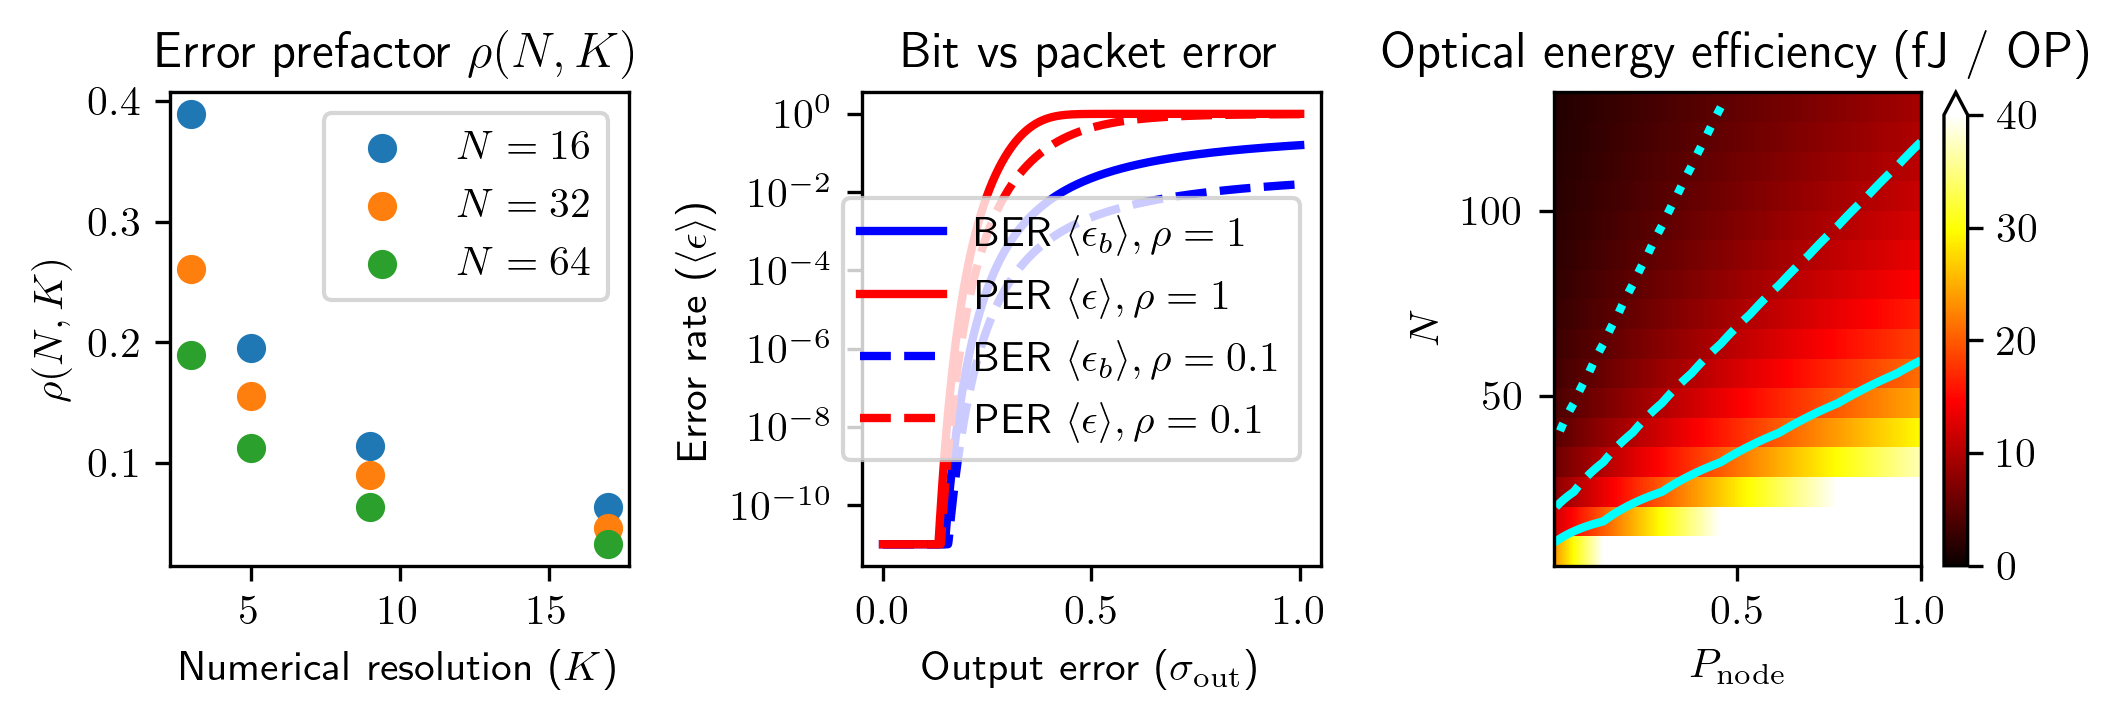

In [15]:
ks = [3, 5, 9, 17]
plt.figure(dpi=300, figsize=(7, 2.5))
plt.subplot(131)
plt.title(r'Error prefactor $\rho(N, K)$')
plt.scatter(ks, [rho[(16, k)] for k in ks])
plt.scatter(ks, [rho[(32, k)] for k in ks])
plt.scatter(ks, [rho[(64, k)] for k in ks])
plt.legend([f'$N = {n}$' for n in (16, 32, 64)])
plt.ylabel(r'$\rho(N, K)$')
plt.xlabel('Numerical resolution ($K$)')
# plt.ylim((0, 100))
plt.subplot(132)
per = np.maximum(10 ** (-11), 0.5 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2)))
per_r = np.maximum(10 ** (-11), 0.05 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2)))
ber = np.maximum(10 ** (-11), 1 - (1 - 0.5 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2))) ** 256)
ber_r = np.maximum(10 ** (-11), 1 - (1 - 0.05 * erfc(1 / np.logspace(-3, 0, 1000) / np.sqrt(2))) ** 256)
plt.title('Bit vs packet error')
plt.plot(np.logspace(-3, 0, 1000), per, color='blue', linewidth=2)
plt.plot(np.logspace(-3, 0, 1000), ber, color='red', linewidth=2)
plt.plot(np.logspace(-3, 0, 1000), per_r, color='blue', linestyle='dashed', linewidth=2)
plt.plot(np.logspace(-3, 0, 1000), ber_r, color='red', linestyle='dashed', linewidth=2)
plt.legend([r'BER $\langle \epsilon_b\rangle, \rho = 1$',
            r'PER $\langle \epsilon\rangle, \rho = 1$',
            r'BER $\langle \epsilon_b\rangle, \rho = 0.1$',
            r'PER $\langle \epsilon\rangle, \rho = 0.1$'])
# plt.ylim((0, 1))
plt.yscale('log')
plt.gca().set_yticks((1, 10 ** -2, 10 ** -4, 10 ** -6, 10 ** -8, 10 ** -10))
plt.ylabel(r'Error rate ($\langle \epsilon \rangle$)')
plt.xlabel(r'Output error ($\sigma_{\mathrm{out}}$)')
plt.subplot(133)
energy_per_op.plot(vmin=0, vmax=40, cmap='hot')
energy_per_op.plot.contour(levels=[5], colors='cyan', linewidths=2, linestyles='dotted')
energy_per_op.plot.contour(levels=[10], colors='cyan', linewidths=2, linestyles='dashed')
energy_per_op.plot.contour(levels=[20], colors='cyan', linewidths=2)
plt.title('Optical energy efficiency (fJ / OP)')
plt.tight_layout()


plt.savefig('simulation_error_scaling.pdf')